### Set up water network model

In this example, we test the VQLS quantum solver with a noisy simulator. Let's start by setting up the model:

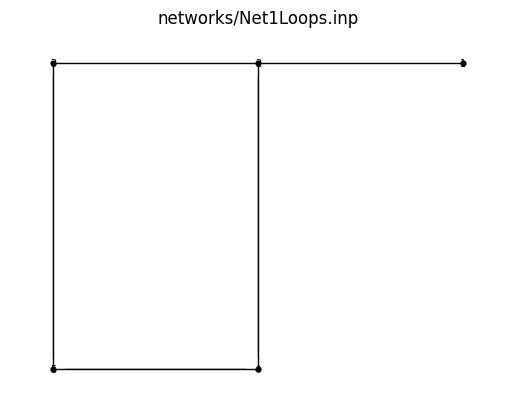

<Axes: title={'center': 'networks/Net1Loops.inp'}>

In [1]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/Users/murilo/scratch_dir/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net1Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [2]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

# load EPANET A and b matrices from temp
epanet_A, epanet_b = wntr_quantum.sim.epanet.load_epanet_matrix()

# check the size of the A and b matrices
epanet_A_dim = epanet_A.todense().shape[0]
epanet_b_dim = epanet_b.shape[0]
print(f"* Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"* Size of the b vector in EPANET simulator: {epanet_b_dim}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

* Size of the Jacobian in EPANET simulator: 4
* Size of the b vector in EPANET simulator: 4


(name          2          3          4          5             1
 0     57.939995  31.496479  52.434612  21.174667  4.394531e-07,
 name         1         2         3         4         5
 0     0.163867  0.059455  0.076645  0.043315  0.031685)

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS and a noisy model.

In [3]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms import optimizers as opt
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

service = QiskitRuntimeService()
# real_hardware = service.backend("ibm_kyoto")  # => asking for a specific backend
real_hardware = service.least_busy()
print(f"* Building a noisy backend from a real ibm hardware: {real_hardware.name}")

options = EstimatorOptions()
options.default_shots = 4000
options.optimization_level = 0
options.resilience_level = 0

###### You can specify all Qiskit Runtime options in local testing mode.
###### However, all options except shots are ignored when run on a local simulator.

## Error suppression: Dynamical Decoupling
#options.dynamical_decoupling.enable = True
#options.dynamical_decoupling.sequence_type = "XX"
#
## Error suppression: Pauli Twirling
#options.twirling.enable_gates = True
#options.twirling.enable_measure = False
#
## Error mitigation: TREX
#options.resilience.measure_mitigation = True
#
## Error mitigation: ZNE
#options.resilience.zne_mitigation = True
#options.resilience.zne.noise_factors = (1, 3, 5)
#options.resilience.zne.extrapolator = ("exponential", "linear")

# set up quantum backend and estimator

# backend = FakeManilaV2()  # => if you want to use a fake hardware model
backend = AerSimulator.from_backend(real_hardware)  # => build a backend model from a real hardware
estimator = Estimator(mode=backend, options=options)

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

res = linear_solver(epanet_A, epanet_b)

* Building a noisy backend from a real ibm hardware: ibm_brisbane


/Users/murilo/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/Vitens/wntr-quantum/.venv/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:247: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 4000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('exponential', 'linear')}}, 'twirling': {'enable_gates': True, 'enable_measure': False}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


VQLS Iteration 90 Cost 9.491e-01
   Normal return from subroutine COBYLA

   NFVALS =   90   F = 9.491052E-01    MAXCV = 0.000000E+00
   X =-2.019814E+00  -1.472090E+00  -2.704428E+00   1.791416E+00   8.681978E-01
       2.051219E+00  -1.539939E+00   1.343982E+00


/Users/murilo/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/Vitens/wntr-quantum/.venv/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:247: UserWarning: Options {'transpilation': {'optimization_level': 0}, 'default_shots': 4000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': ('exponential', 'linear')}}, 'twirling': {'enable_gates': True, 'enable_measure': False}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


         Current function value: 0.953355
         Iterations: 0
         Function evaluations: 228
         Gradient evaluations: 24


Let's check the evolution of the cost function

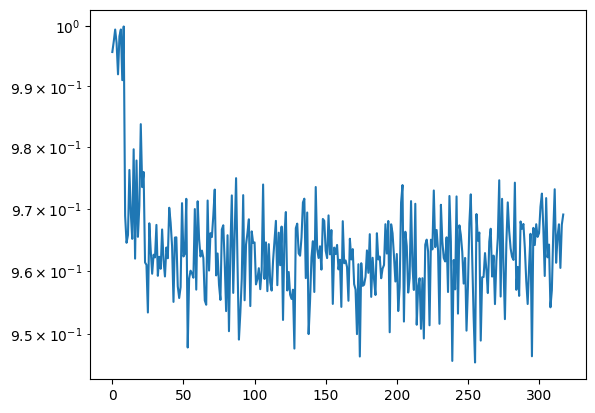

In [4]:
import matplotlib.pyplot as plt
plt.semilogy(res.logger.values)

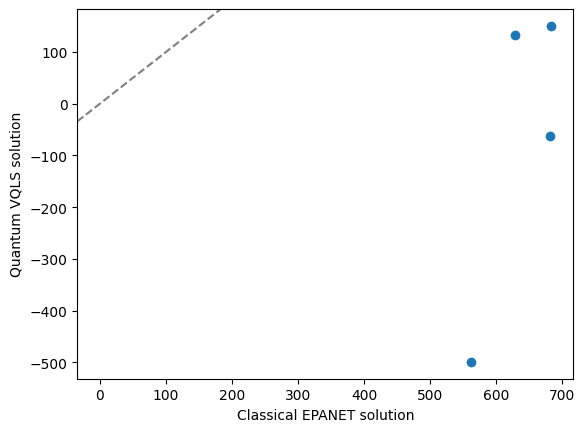

(array([561.597, 628.269, 682.218, 680.56 ]),
 array([-498.943,  132.724,  150.426,  -63.186]))

In [5]:
import numpy as np 
ref = np.linalg.solve(epanet_A.todense(), epanet_b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.xlabel("Classical EPANET solution")
plt.ylabel("Quantum VQLS solution")
plt.show()

ref, res.solution